<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/AE_v6_multiple_leads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer 
import glob
import torch.optim as optim
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

import requests
import zipfile
from pathlib import Path

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

In [41]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [42]:
# Setup path to data folder
data_path = Path("data/")
train_path = data_path / "train_data"


# If the image folder doesn't exist, download it and prepare it... 
if train_path.is_dir():
    print(f"{train_path} directory exists.")
else:
    print(f"Did not find {train_path} directory, creating one...")
    train_path.mkdir(parents=True, exist_ok=True)

    # # importing the "tarfile" module
    # import tarfile
    # # open file
    # file = tarfile.open('/content/gdrive/MyDrive/Internship_SIMULA/pulse2pulse_150k.tar.gz')
    # # extracting file
    # file.extractall(train_path)
    # file.close()

    # Unzip pizza, steak, sushi data
with zipfile.ZipFile("/content/gdrive/MyDrive/Simula/ecg_25000.zip", "r") as zip_ref:
    print(f"Unzipping data to folder...") 
    zip_ref.extractall(train_path)

data/train_data directory exists.
Unzipping data to folder...


In [4]:
# from tqdm.auto import tqdm
# max_list=[]
# data_dir_test="/content/data/train_data/from_006_chkp_2500_150k"
# #data_dir_train = "/content/data/train_data/sub_data/train"
# files=glob.glob(data_dir_test + '/*.asc')
# #files_train=glob.glob(data_dir_train + '/*.asc')
# #files=[*files_test,*files_train]
# for file in tqdm(files):
#   temp_df=pd.read_csv(file,sep=" ",header=None)
#   max=temp_df.max().max()
#   max_list.append(max)

In [43]:
# Create custom dataset class to load ECG data into dataset, containing 
# input tensor with lead 1 and output tensor with desired other leads
class Custom_dataset(Dataset):
    def __init__(self, data_dir,max_value=5011,column=3,split=False,train=True):
      #get all files from directory loaded in all_files list
      self.column=column
      self.max_value=max_value
      self.files = glob.glob(data_dir + '/*.asc')
      self.len=len(self.files)
      self.cut=int(self.len*0.8)
      self.train_files=self.files[0:self.cut]
      self.test_files=self.files[self.cut:self.len]
      self.train=train
      self.split=split

    def __len__(self):
      if self.split is True:
        if self.train is True:
          return len(self.train_files)
        if self.train is not True:
          return len(self.test_files)
      if self.split is not True:
        return len(self.files)

    def __getitem__(self,idx):
      header = [x for x in range(8)]
      #turn list of dataframes into Tensor
      if self.split is True:
        if self.train is True:
          temp_df=pd.read_csv(self.train_files[idx],sep=" ", names = header)
        if self.train is not True:
          temp_df=pd.read_csv(self.test_files[idx],sep=" ", names = header)
      if self.split is not True:
        temp_df=pd.read_csv(self.files[idx],sep=" ", names = header)
      temp_df/=self.max_value
      #load input tensor
      
      temp_list_in=temp_df.iloc[:,0]
      #temp_list_in=normalize([temp_list_in], norm="max")
      temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.float32)
      temp_tensor_in=temp_tensor_in.unsqueeze(0)
      #load label Tensor
      temp_list_out=temp_df.iloc[:,1:9].values
      #temp_list_out=normalize([temp_list_out], norm="max")
      temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.float32)
      temp_tensor_out=temp_tensor_out.unsqueeze(0)
      temp_tensor_out=torch.permute(temp_tensor_out,(0,2,1))
      #combine input and label and output
      temp_tensor_pair= temp_tensor_in,temp_tensor_out
      return temp_tensor_pair

In [44]:
data_dir="/content/data/train_data"
train_dataset = Custom_dataset(data_dir=data_dir,split=True,train=True)
test_dataset = Custom_dataset(data_dir=data_dir,split=True,train=False)

In [45]:
x,y=train_dataset[0]
x.shape,y.shape

(torch.Size([1, 5000]), torch.Size([1, 7, 5000]))

In [8]:
# header = [x for x in range(8)]
# df = pd.read_csv("/content/data/train_data/0.asc",sep=" ",names = header)
# df.head()

In [46]:
x,y=train_dataset[0]
x.shape,y.shape

(torch.Size([1, 5000]), torch.Size([1, 7, 5000]))

In [47]:
from torch.utils.data.dataloader import DataLoader
BATCH_SIZE = 128
#turn datasets into iterables
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                             drop_last=True
                              )

In [48]:
"""
Here, we define the autoencoder model.This model is taken from "https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py"
"""
class ECG_AE_v1(nn.Module):
    def __init__(self):
        super(ECG_AE_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(5000, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,35000),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = ECG_AE_v1().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [49]:
def train_model(Epochs=20,model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader):
  epoch_count = []
  test_count = []
  train_count = []
  from tqdm.auto import tqdm
  #train and test loop
  for epoch in tqdm(range(Epochs)):
    print(f"Epoch:{epoch}")
    train_loss=0
    for batch, (X,y) in enumerate(tqdm(train_dataloader)):
      #print("doing train loop")
      X, y = X.to(device), y.to(device) 
      model.train()
      output=model(X)
      output=torch.reshape(output,(128, 1, 7, 5000))
      #print(output.shape,y.shape)
      loss = criterion(output,y)
      #print(loss)
      train_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #print(train_loss)
    #average loss per batch
    train_loss /= len(train_dataloader)
    #start testing
    test_loss = 0
    model.eval()
    with torch.inference_mode():
      for X,y in test_dataloader:
        #print("doing test loop")
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        test_pred=torch.reshape(test_pred,(128, 1, 7, 5000))
        ##reshaping output from linear to 2d from 40000 to 8 times 5000
        #test_pred=torch.reshape(test_pred,(10,1,8,4999))
        ######
        test_loss += criterion(test_pred,y)    
      test_loss /= len(test_dataloader)

    #print what is happening
    if epoch % 1 == 0:
      print(f"\nTrain loss: {train_loss:.5f} |test_loss:{test_loss}" )
      epoch_count.append(epoch)
      test_count.append(test_loss.item())
      train_count.append(train_loss.item())
    if epoch % 1 == 0:
      print("saving model")
      torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Simula/model_outcome/model1_7{epoch}")
      training_progress = pd.DataFrame(
    {'Epoch': epoch_count,
     'Train_loss': train_count,
     'Test_loss': test_count
    })
      training_progress.to_csv("/content/gdrive/MyDrive/Simula/model_outcome/progress_normalized.csv")


In [58]:
train_model(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0


  0%|          | 0/156 [00:00<?, ?it/s]


Train loss: 0.00157 |test_loss:0.0015543141635134816
saving model
Epoch:1


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

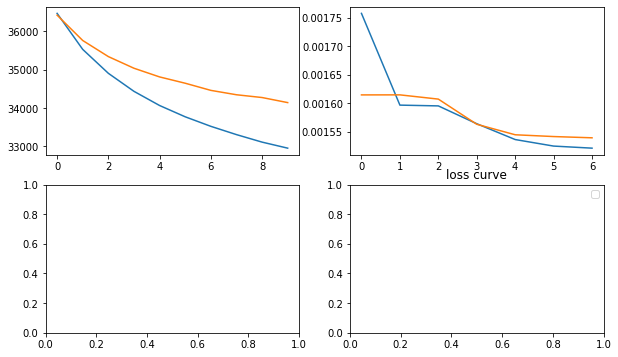

In [44]:
df = pd.read_csv("/content/gdrive/MyDrive/Simula/model_outcome/progress.csv")
df_normal = pd.read_csv("/content/gdrive/MyDrive/Simula/model_outcome/progress_normalized.csv")
X=df["Epoch"]
y_test=df["Test_loss"]
y_train=df["Train_loss"]
X_normal=df_normal["Epoch"]
y_test_normal=df_normal["Test_loss"]
y_train_normal=df_normal["Train_loss"]
fig,axs = plt.subplots(2,2,figsize=(10,6))
#plt.figure(figsize=(10,6))
plt.title("loss curve")
axs[0,0].plot(X,y_train,label="Train_loss")
axs[0,0].plot(X,y_test,label="Test_loss")
axs[0,1].plot(X_normal,y_train_normal,label="Train_loss")
axs[0,1].plot(X_normal,y_test_normal,label="Test_loss")
plt.legend()

In [ ]:
# input,output = test_dataset[0]
# input=input.tolist()
# data=input[0]
# type(data)
# plt.plot(data)
# # plt.title("Input ECG lead1")

In [61]:
model = ECG_AE_v1()
PATH="/content/gdrive/MyDrive/Simula/model_outcome/model1_70"
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [62]:
X,y=test_dataset[0]
model.to("cpu")
model.eval()
with torch.inference_mode():
  output=model(X)
  print(output.shape)
  output=torch.reshape(output,(5000, 7))
  print(output.shape)
output=output.detach().numpy()
#output=output.tolist()
#header = [x for x in range(8)]
df = pd.DataFrame(output,columns=["2","v1","v2","v3","v4","v5","v6"])*5011
df.head()


torch.Size([1, 35000])
torch.Size([5000, 7])


,2,v1,v2,v3,v4,v5,v6
0,21.073391,10.839317,-14.900081,-70.501953,-62.199638,-11.596926,-14.162344
1,-40.415890,9.137352,-38.022335,-28.117498,-15.330225,-24.107697,-5.019970
2,-18.069914,-11.015445,-16.362581,-15.932184,-34.118313,-21.279877,-7.130846
3,-19.300348,-14.603567,-20.797215,-21.134350,-31.495071,-6.166804,-10.301770
4,-29.058310,-10.705117,-23.435036,-36.992386,-10.552670,-15.193076,-25.615110


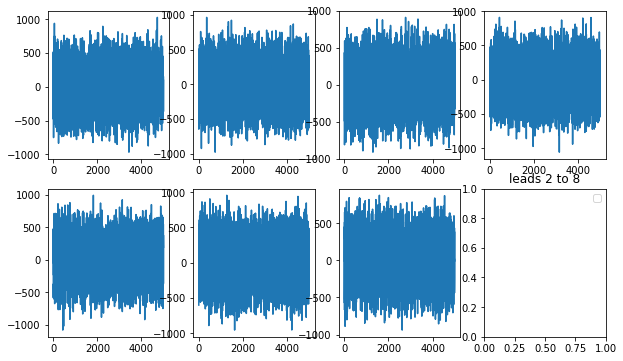

In [57]:
columns=["2","v1","v2","v3","v4","v5","v6"]
fig,axs = plt.subplots(2,4,figsize=(10,6))
#plt.figure(figsize=(10,6))
plt.title("leads 2 to 8")
axs[0,0].plot(df[columns[0]])
axs[0,1].plot(df[columns[1]])
axs[0,2].plot(df[columns[2]])
axs[0,3].plot(df[columns[3]])
axs[1,0].plot(df[columns[4]])
axs[1,1].plot(df[columns[5]])
axs[1,2].plot(df[columns[6]])


plt.legend()